In [1]:
!git clone https://github.com/shiftmark/HPA-SingleCellClassification.git
#!git clone https://github.com/CellProfiling/HPA-Cell-Segmentation.git
#!cd HPA-Cell-Segmentation && sh install.sh
#!pip uninstall PIL && pip uninstall Pillow -y && pip install Pillow
# restart for Pillow

Cloning into 'HPA-SingleCellClassification'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 267 (delta 131), reused 199 (delta 70), pack-reused 0
Receiving objects: 100% (267/267), 5.18 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [2]:
import sys
import os
import random
import cv2
sys.path.insert(0, '/content/HPA-SingleCellClassification/src/')
sys.path.insert(0, '/content/HPA-SingleCellClassification/tests/')

import test_download_images_and_save_masks as dg
#test.test_on(num_img=10)

from utils.download_files import DownloadFile
from utils.create_tfrecord import CreateTFRecord
from utils.parse_example import ParseExample
from train.helpers import plot_images, plot_history
from train.augment import Augment

SAVE_IMG_TO = GET_IMG_FROM = '/content/sample_data/hpa/images'
SAVE_TFREC_TO = '/content/sample_data/hpa/tfrec'
SAVE_MASKS_TO = '/content/sample_data/hpa/masks'



There are 72007 images in the dataset.

The dataset head is: 
                                            Image  ... Label_idx
0  https://images.proteinatlas.org/10005/921_B9_1  ...        16
1  https://images.proteinatlas.org/10005/921_B9_2  ...        16
2  https://images.proteinatlas.org/10005/923_B9_1  ...        16
3  https://images.proteinatlas.org/10005/923_B9_2  ...        16
4  https://images.proteinatlas.org/10005/931_B9_1  ...        16

[5 rows x 5 columns].


In [ ]:
dg.download(8, SAVE_IMG_TO)

In [9]:
img_names = sorted(os.listdir(f'{GET_IMG_FROM}/tc'))
labels = dict()

for img_name in img_names:
    dummy_label = random.randint(0,18)
    name = img_name.split('.')[0]
    labels[name] = dummy_label


In [10]:
img_names

['1901_A10_2.png',
 '1901_A10_3.png',
 '921_B9_1.png',
 '921_B9_2.png',
 '923_B9_1.png',
 '923_B9_2.png',
 '931_B9_1.png',
 '931_B9_2.png']

In [8]:
!rm -rf '/content/sample_data/hpa/images/tc/.ipynb_checkpoints'

In [11]:
CreateTFRecord(f'{GET_IMG_FROM}/tc', labels).write_to(SAVE_TFREC_TO)

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

imgs = []#'/content/sample_data/hpa/images/921_B9_1_blue.png']

dataset = tf.data.TFRecordDataset(f'{SAVE_TFREC_TO}/record.tfrec')

for i in dataset.take(10):
    #print(i.shape)
    imgs.append(ParseExample(i, return_img_name=True).parse_eg()[1])
    #imgs.append(tf.squeeze(ParseExample(i, return_img_name=False).parse_eg()[0]).numpy())
data = tf.data.Dataset.from_tensor_slices(imgs)
data2 = Augment(flip_horizontal=False,
                seed=tf.random.uniform((2,),maxval=9, dtype=tf.int32),
                contrast={'lower':.1, 'upper':.9},
                brightness={'max_delta':.1},
                saturation={'lower':.2, 'upper':.7}
                ).apply_on(data)

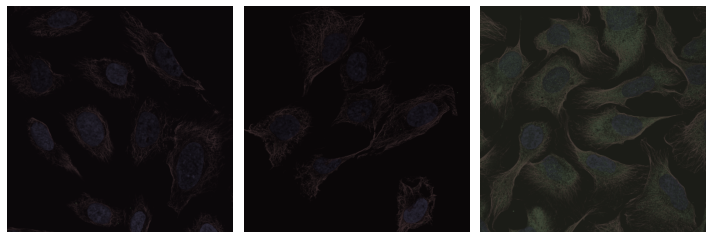

In [15]:
imgss = []
for i in data2.take(3):
    imgss.append(i.numpy())
plot_images(imgss, show_axes=False)

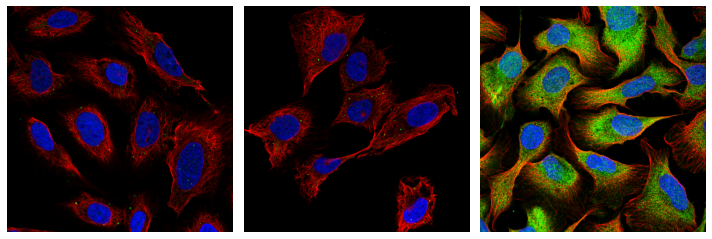

In [16]:
imgsss = []
for i in data.take(3):
    imgsss.append(i.numpy())
plot_images(imgsss, show_axes=False)

In [ ]:
#model_got = GetModel().set_backbone("EfficientNetB0", (224,224,3), include_top=True)
#model = tf.keras.Model(inputs=model_got.inputs, outputs=model_got.outputs)
#model.summary()


model2 = GetModel().set_backbone("EfficientNetB7", input_shape=(600,600,3), include_top=False).add_top(23,.4,33)

#model = Unet((32, 800, 3), 7).unet()

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(model2)